 ## Exploratory and Statistical Analysis of the Bank Marketing Dataset

This notebook is part of a broader project aimed at predicting whether a client will subscribe to a term deposit (`y`) using the Bank Marketing dataset. 

In this section, the focus is on **Exploratory Data Analysis (EDA)**, examining the dataset’s structure, quality, and underlying patterns to uncover insights that can guide data preparation and modeling decisions.

The objectives are to:
- Examine the dataset’s structure and data quality  
- Explore feature distributions and relationships  
- Conduct statistical tests to identify significant predictors  
- Generate early insights to support feature selection and model development  

### Familiarizing with the Dataset

This dataset contains **750,000,000 rows and 18 columns**, describing client demographics, financial indicators, and marketing campaign interactions.  
Below is a brief overview of key variables:

| Variable | Description |
|-----------|-------------|
| age | Age of the client |
| job | Type of job (e.g., admin, technician, blue-collar, management, etc.) |
| marital | Marital status (married, single, divorced) |
| education | Education level (primary, secondary, tertiary, unknown) |
| balance | Average yearly account balance (in euros) |
| duration | Last contact duration in seconds |
| campaign | Number of contacts during this campaign |
| poutcome | Outcome of the previous marketing campaign |
| y | Target variable — whether the client subscribed to a term deposit |


### Import packages 

In [5]:

# For data manipulation
import numpy as np
import pandas as pd
from pathlib import Path


# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for statistical tests 
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency


###  Load dataset

In [7]:
# Move one level up (to the project root), then into data/raw
data_dir = Path().resolve().parent / "data" / "raw"

# Load dataset
df = pd.read_csv(data_dir / "train.csv")

print(f" Dataset loaded successfully from: {data_dir}")
df.head()


 Dataset loaded successfully from: C:\Users\hp\Documents\DA projects\Bank Marketing Prediction\data\raw


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


### Data Exploration

In [9]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [10]:
df.shape

(750000, 18)

In [11]:
# Count 'unknown' values across all columns
(df == 'unknown').sum()


id                0
age               0
job            2917
marital           0
education     21299
default           0
balance           0
housing           0
loan              0
contact      231627
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome     672450
y                 0
dtype: int64

In [12]:
# Check for duplicates
df.duplicated().sum()

0

##### Target Variable Exploration `y`

Goal: Understand balance and class distribution of target variable `y`

In [14]:
# Get number of people who subscribed vs those who didn't
print(df['y'].value_counts())
print()

# Get percentages of people who left vs. stayed
print(df['y'].value_counts(normalize=True))

y
0    659512
1     90488
Name: count, dtype: int64

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


Only about 12% of clients subscribed to a term deposit, indicating a typical marketing challenge where conversion rates remain low despite extensive outreach efforts.
This class imbalance will need to be accounted for during modeling through techniques such as class weighting, resampling, or stratified sampling.

##### Campaign History Consistency Check

A brief logic check was conducted between the `pdays` (days since last contact) 
and `previous` (number of prior contacts) variables.


In [18]:
# --- Check for inconsistencies between 'pdays' and 'previous' ---

# Case 1: 'pdays = -1' (no prior contact) but 'previous' > 0
inconsistent_1 = df[(df['pdays'] == -1) & (df['previous'] > 0)]

# Case 2: 'pdays != -1' (had prior contact) but 'previous' = 0
inconsistent_2 = df[(df['pdays'] != -1) & (df['previous'] == 0)]

# Print summary
print("=== Consistency Check between 'pdays' and 'previous' ===")
print(f"Case 1: pdays = -1 but previous > 0  --> {inconsistent_1.shape[0]} rows")
print(f"Case 2: pdays != -1 but previous = 0 --> {inconsistent_2.shape[0]} rows")
print(f"Total inconsistent entries: {inconsistent_1.shape[0] + inconsistent_2.shape[0]}")


=== Consistency Check between 'pdays' and 'previous' ===
Case 1: pdays = -1 but previous > 0  --> 17 rows
Case 2: pdays != -1 but previous = 0 --> 14 rows
Total inconsistent entries: 31


A small number of records display inconsistencies between `pdays` and `previous`.
Given the variable definitions, these combinations are implausible and likely due to data entry or merging errors.
The affected records (<0.005%) are negligible and can be safely ignored or removed without affecting analysis validity. 

A similar  logical check was also conducted between the `previous` variable and `poutcome`

In [20]:
# Identify records where previous > 0 but poutcome == 'unknown'
poutcome_inconsistent = df[(df['previous'] > 0) & (df['poutcome'] == 'unknown')]

# Display the count
print("Number of inconsistent records:", poutcome_inconsistent.shape[0])


Number of inconsistent records: 36


A minor inconsistency was found where some clients had previous contacts (previous > 0) but an unknown previous campaign outcome (poutcome = 'unknown'). These represent <0.01% of records and likely reflect missing logs, so they were retained.

#### Correlation Analysis (Numeric Features)

This section examines the relationships among numeric features using correlation analysis. Identifying strong correlations helps detect potential multicollinearity and guides feature selection for modeling.

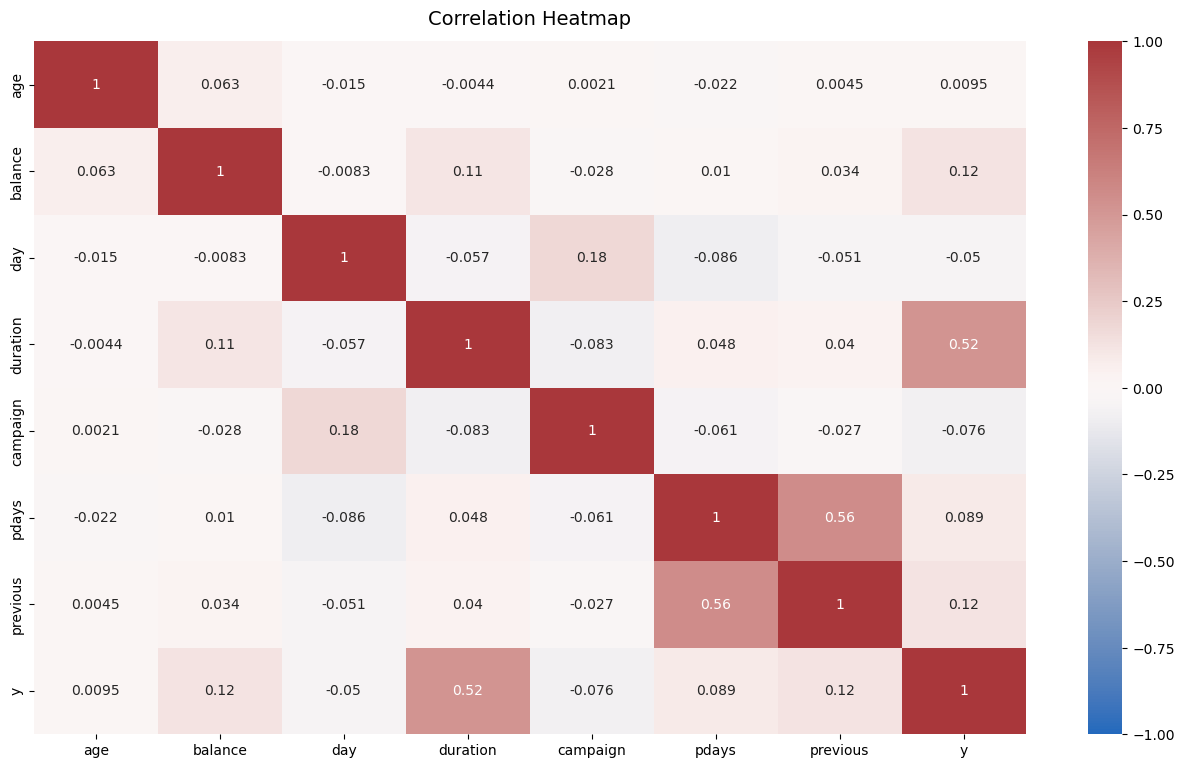

In [24]:
# Plot a correlation heatmap excluding the 'id' column

# Select only numeric columns, excluding 'id'
numeric_df = df.select_dtypes(include=['number']).drop(columns=['id'], errors='ignore')

# Plot correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(
    numeric_df.corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True)
)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()


The correlation heatmap shows limited linear relationships among features.
The strongest association is between duration and the target variable (`y`), indicating that longer calls may correspond to higher subscription likelihoods.
The `pdays`–`previous` relationship suggests a structural linkage in campaign history tracking.

### Univariate Analysis(Numerical Features)
The analysis of numerical features was conducted by generating histograms and box plots to assess the distribution shape and identify potential outliers visually. This was supplemented with a table of descriptive statistics (e.g., mean, median, standard deviation) for each numeric variable.

In [26]:
# Gather descriptive statistics about the data
df.describe()


,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


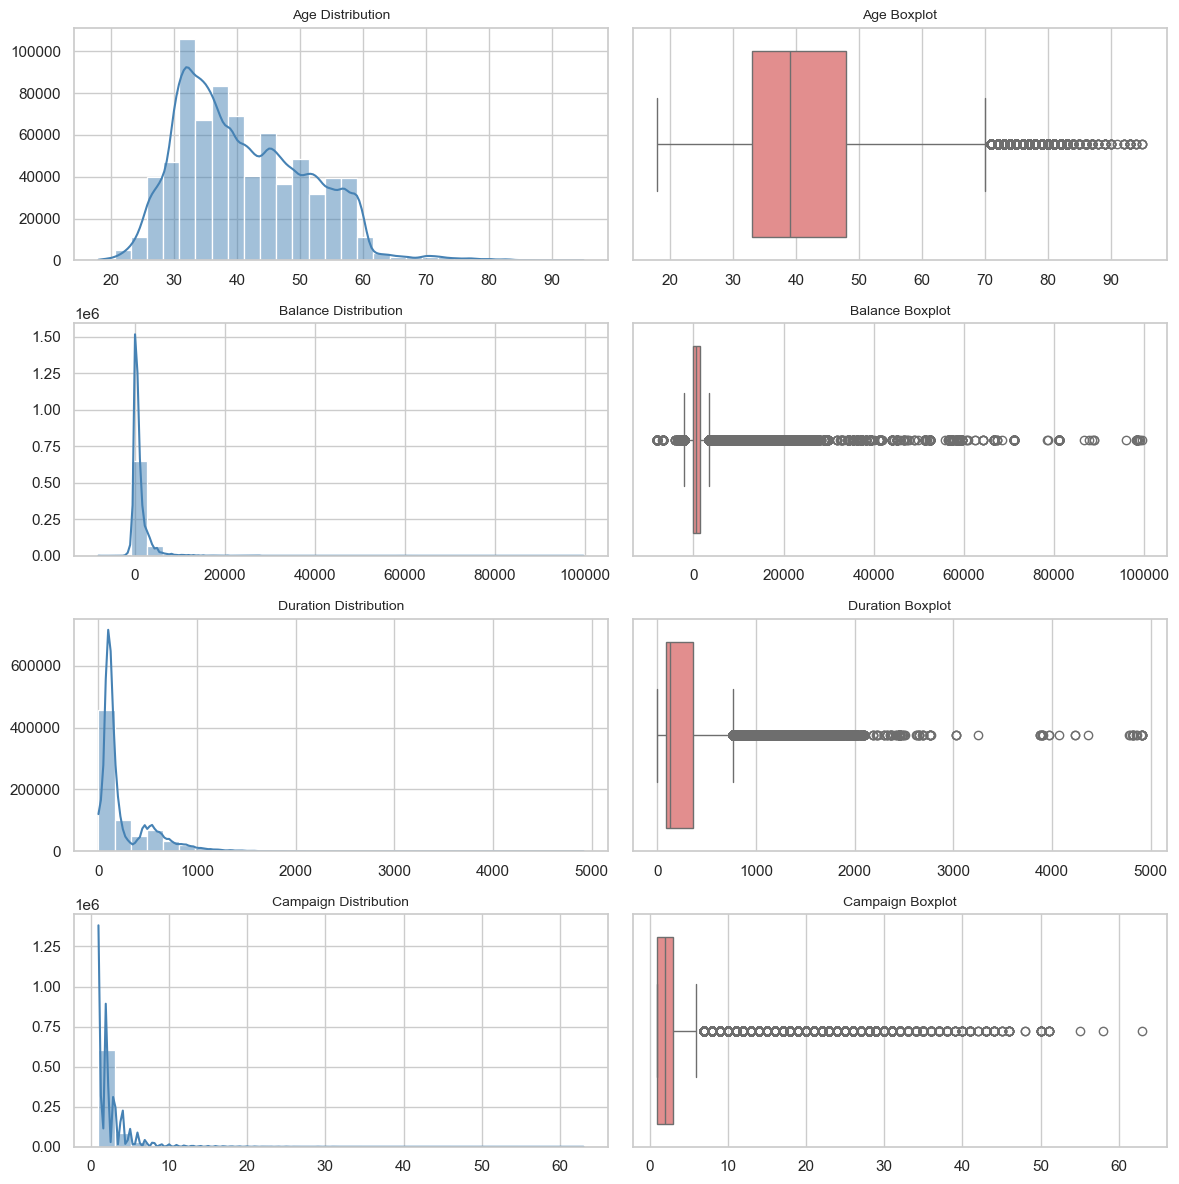

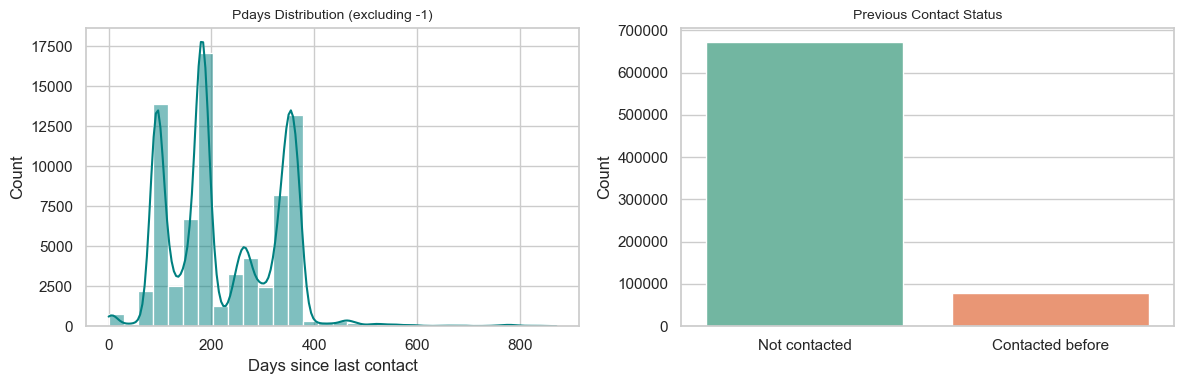

In [27]:
# Set overall aesthetic
sns.set(style="whitegrid", palette="pastel")

# List of numeric variables to visualize
num_vars = ['age', 'balance', 'duration', 'campaign']

# ---Side-by-side histogram + boxplot for main numeric features ---
fig, axes = plt.subplots(len(num_vars), 2, figsize=(12, 12))
for i, col in enumerate(num_vars):
    # Histogram
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i, 0], color='steelblue')
    axes[i, 0].set_title(f'{col.capitalize()} Distribution', fontsize=10)
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col.capitalize()} Boxplot', fontsize=10)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show()

# ---  Special handling for 'pdays' ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Histogram excluding -1
sns.histplot(df.loc[df['pdays'] != -1, 'pdays'], bins=30, kde=True, ax=ax[0], color='teal')
ax[0].set_title('Pdays Distribution (excluding -1)', fontsize=10)
ax[0].set_xlabel('Days since last contact')
ax[0].set_ylabel('Count')

# Barplot showing frequency of -1 vs contacted
df['was_contacted'] =df['pdays'].apply(lambda x: 'Not contacted' if x == -1 else 'Contacted before')
sns.countplot(x='was_contacted', data=df, hue='was_contacted', ax=ax[1], palette='Set2', legend=False)
ax[1].set_title('Previous Contact Status', fontsize=10)
ax[1].set_xlabel('')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Overall, the numeric variables show noticeable right-skewed distributions with varying degrees of spread and outliers. Most clients fall within the 30–50 age range, reflecting a primarily working-age customer base. Account balances are concentrated near zero, though a small fraction of clients hold very large balances, suggesting income disparity and the potential need for log transformation. The duration of the last contact tends to be short, yet longer calls may indicate higher engagement or a greater likelihood of subscription. Similarly, the campaign variable shows that most clients are contacted only a few times, with extreme outliers representing harder-to-reach individuals.

The `pdays` variable is unique — a large portion of values are recorded as -1, representing clients who had never been contacted before. For clients who were previously contacted, the days since their last contact vary considerably, though most had been contacted fairly recently. For this reason, it may be more meaningful when treated as a binary indicator (contacted vs. not contacted) rather than as a continuous numeric measure.

### Check outliers 

This section quantifies the extent of extreme values across all numeric variables using the interquartile range (IQR) method

In [31]:
# --- Outlier Detection Across All Numeric Variables Using IQR ---

# Select only numeric columns, excluding id, y, and day
exclude_cols = ['id', 'y', 'day']
numeric_cols = df.select_dtypes(include=['number']).drop(columns=exclude_cols, errors='ignore')

# Dictionary to store outlier counts per column
outlier_summary = {}

for col in numeric_cols.columns:
    # Compute quartiles and IQR
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define limits
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = numeric_cols[(numeric_cols[col] < lower_limit) | (numeric_cols[col] > upper_limit)]
    outlier_count = outliers.shape[0]
    outlier_percentage = (outlier_count / len(numeric_cols)) * 100
    
    # Store results
    outlier_summary[col] = {
        'Lower Limit': lower_limit,
        'Upper Limit': upper_limit,
        'Outlier Count': outlier_count,
        'Outlier %': round(outlier_percentage, 2)
    }

# Convert summary to a DataFrame for display
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='Outlier %', ascending=False)
print("Outlier Summary by Numeric Feature:")
display(outlier_df)



Outlier Summary by Numeric Feature:


,Lower Limit,Upper Limit,Outlier Count,Outlier %
pdays,-1.0,-1.0,77566.0,10.34
previous,0.0,0.0,77569.0,10.34
balance,-2085.0,3475.0,57745.0,7.70
duration,-314.0,766.0,46118.0,6.15
campaign,-2.0,6.0,40686.0,5.42
age,10.5,70.5,4903.0,0.65


The outlier analysis revealed that most flagged values are not genuine anomalies but reflections of the dataset’s structure. Specifically, the high counts for pdays and previous arise from placeholder values (-1 and 0) representing clients who had not been previously contacted, rather than true outliers. For balance, duration, and campaign, the detected extremes likely reflect genuine behavioral variability—such as unusually high account balances, long call durations, or repeated contact attempts—common in marketing data.The few outliers in age correspond to clients aged above 85, who are rare but valid within the population. Overall, the outliers appear contextually valid and do not indicate significant data quality issues

#### Univariate Analysis (Categorical Features)

The analysis of categorical variables was performed using countplots to visualize the frequency distribution of each category and detect class imbalances. These visuals help identify dominant groups across features such as job, marital status, education, loan, and contact type, providing insight into the overall composition of the client base. Where relevant, categories were compared against the target variable to highlight potential differences in subscription behavior across groups.

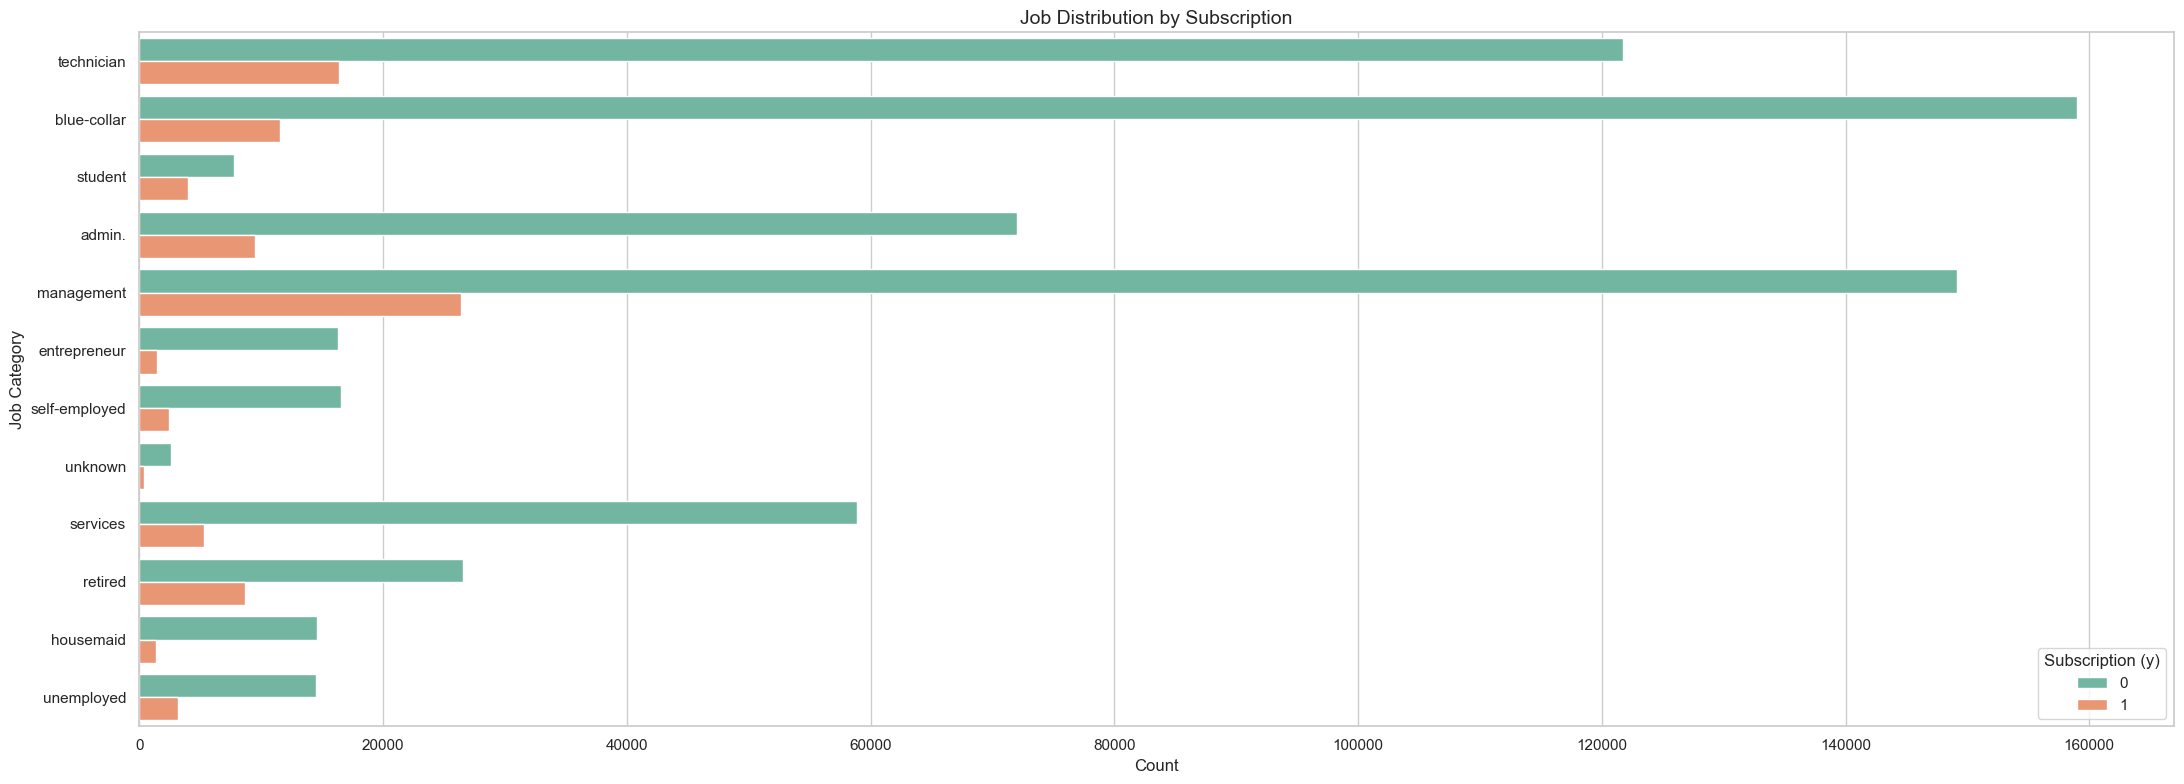

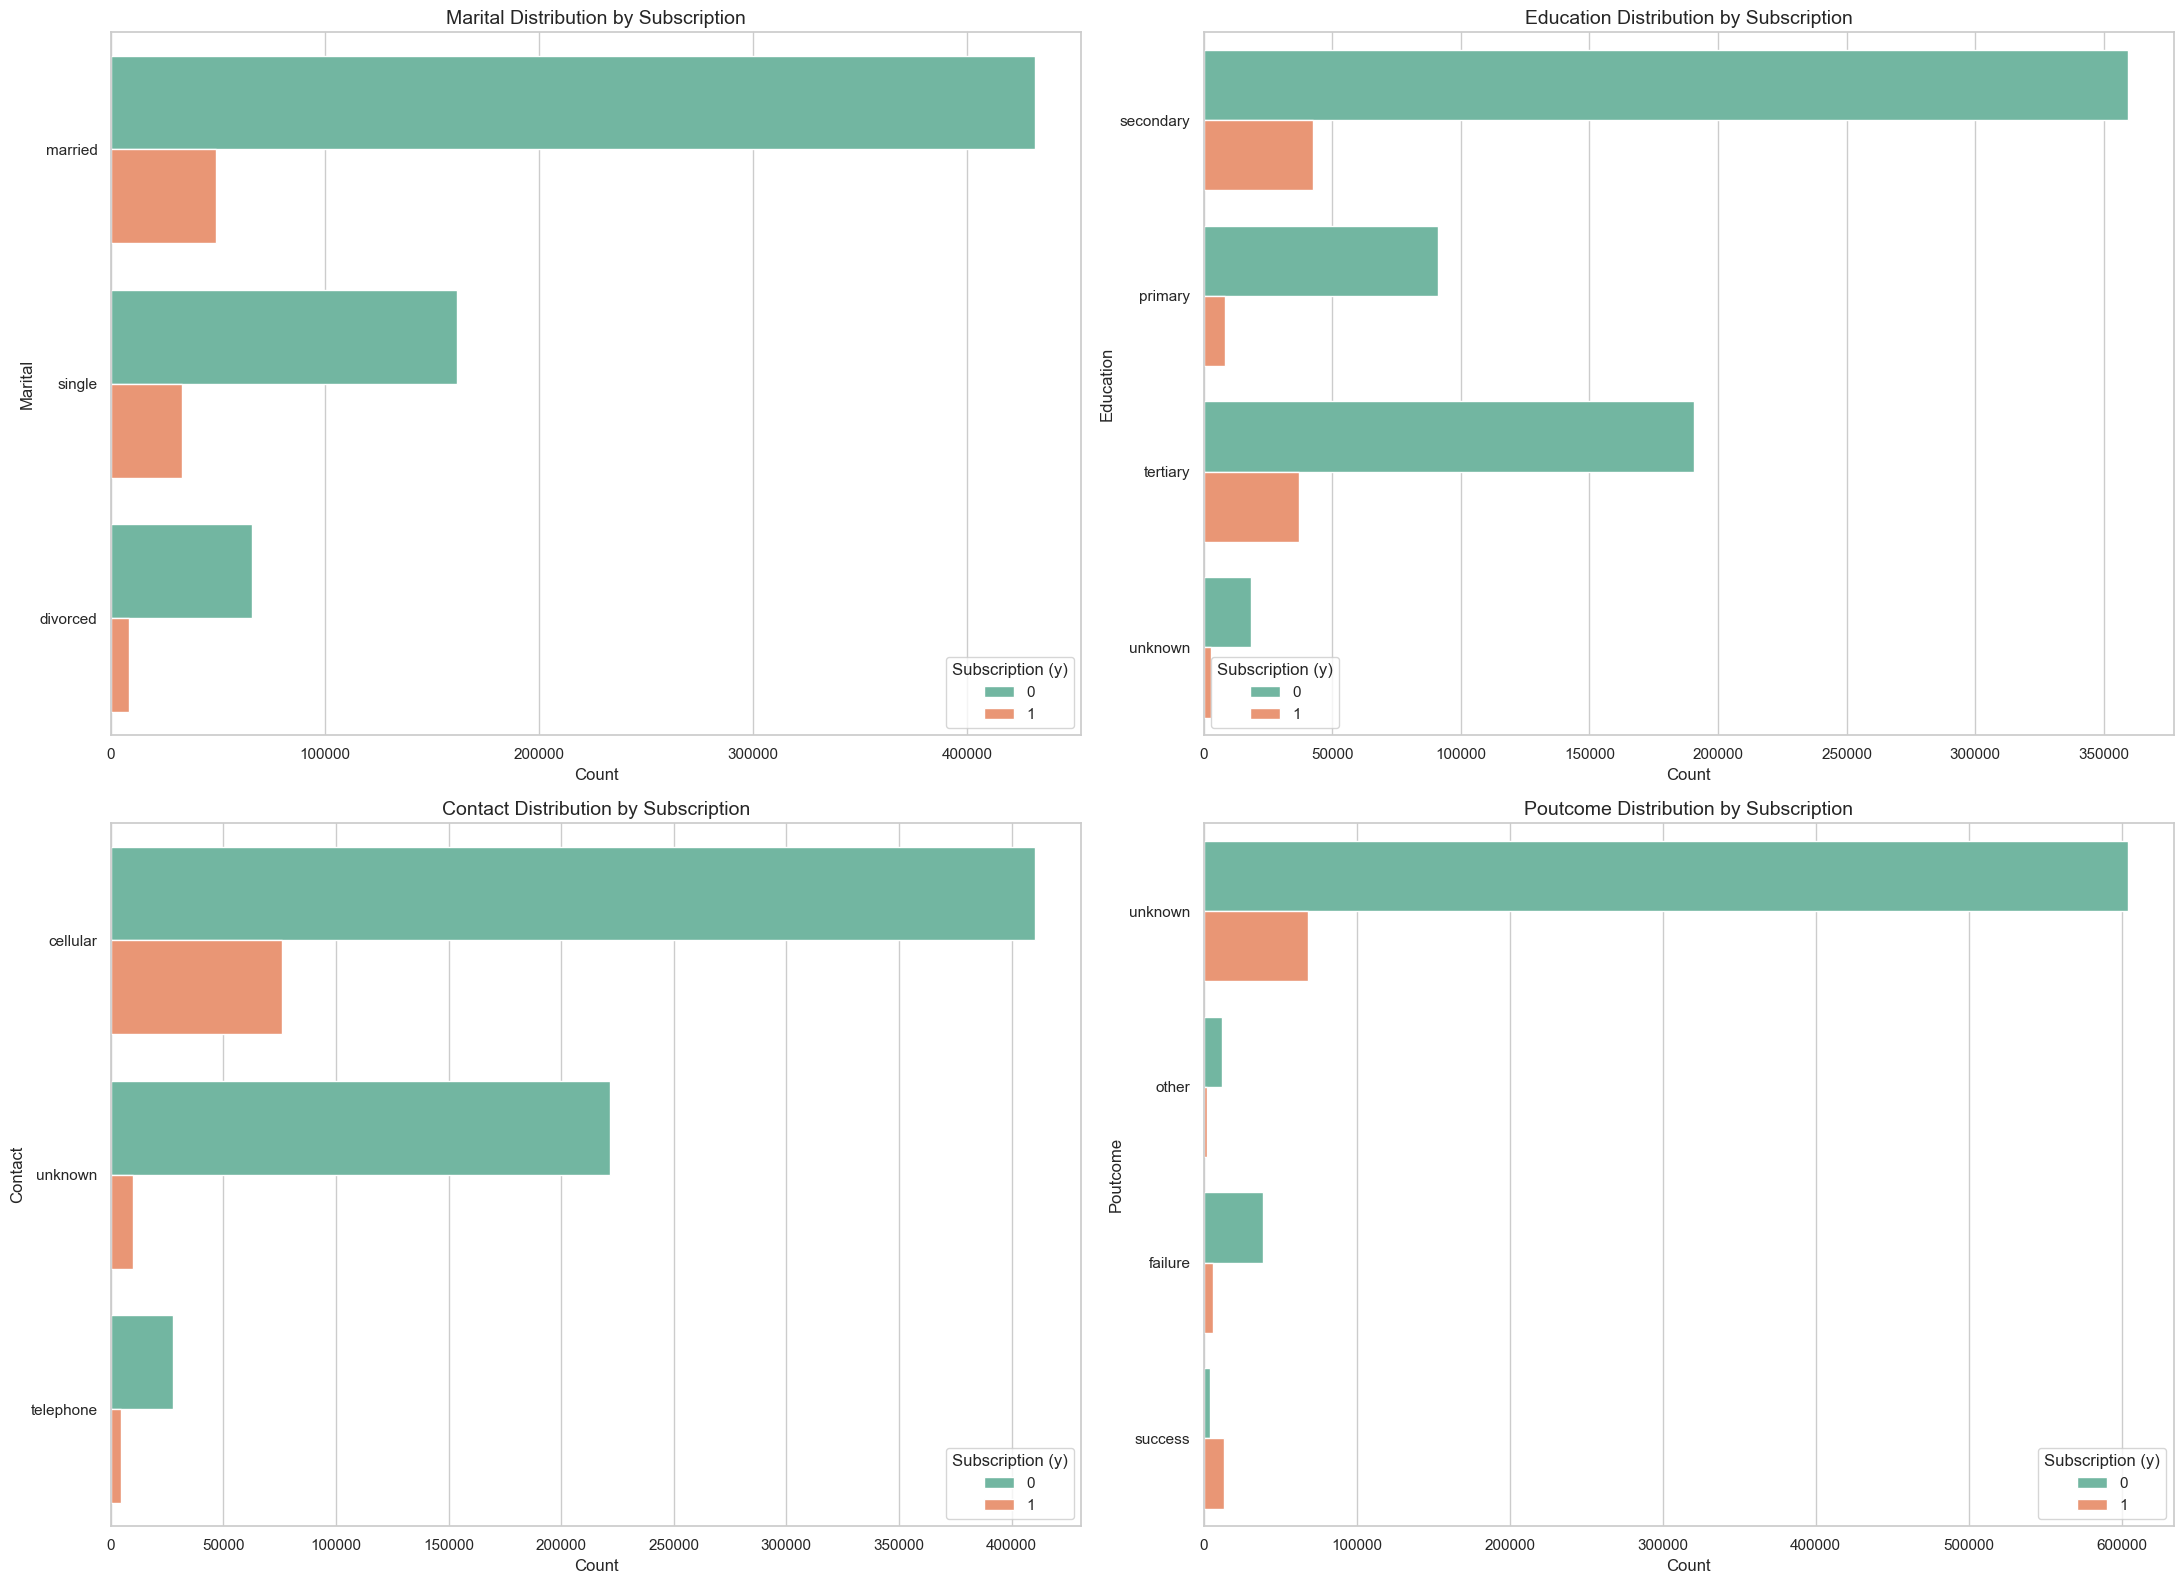

In [35]:

# Set style and palette
sns.set(style="whitegrid", palette="Set2")

# Define key categorical variables to visualize
categorical_vars = ['marital', 'education','contact', 'poutcome']

# ---- Plot 1: Job Distribution (horizontal for clarity) ----
fig, ax = plt.subplots(1, 1, figsize=(22, 8))
sns.countplot(data=df, y='job', hue='y', palette='Set2', ax=ax)
ax.set_title('Job Distribution by Subscription', fontsize=14)
ax.set_xlabel('Count')
ax.set_ylabel('Job Category')
ax.legend(title='Subscription (y)')
plt.tight_layout()
plt.show()

# ---- Plot 2: Other Key Categorical Variables ----
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(data=df, y=col, hue='y', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col.capitalize()} Distribution by Subscription', fontsize=14)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col.capitalize())
    axes[i].legend(title='Subscription (y)')
    axes[i].tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.show()


The distribution of categorical variables reveals several notable patterns. Most clients work in blue-collar, management, or technician roles, with relatively fewer in services or admin positions. Subscription rates appear slightly higher among management and retired clients compared to others. Married individuals dominate the dataset, though singles seem marginally more responsive to subscriptions. Education-wise, clients with tertiary education show a higher proportion of positive responses. Contact through cellular phones was the most common and effective, while telephone and unknown contacts show limited success. Previous campaign outcomes (especially “success”) and prior contact history correlate strongly with a higher likelihood of subscription.

#### Bivariate Statistical Testing (Categorical Variables vs Target)

##### Chi- Squared Test of independence

To evaluate how each categorical feature relates to the likelihood of a client subscribing to a term deposit, a Chi-Squared Test of Independence was conducted.

Contingency tables were first created to cross-tabulate each categorical variable with the target variable (y), showing the distribution of subscribers (y = 1) and non-subscribers (y = 0) across categories such as job, education, contact method, and previous campaign outcome.

The Chi-Squared test then assessed whether the observed differences between these categories are statistically significant or merely due to random variation.

Null Hypothesis ($H_0$): There is no association between the categorical feature and subscription outcome.

Alternative Hypothesis ($H_1$): There is a significant association between the categorical feature and subscription outcome.

Significance Level (α): 0.05

A low p-value (< 0.05) suggests that the relationship between a feature and subscription status is unlikely to have occurred by chance — indicating that the feature may hold predictive importance.

In [39]:
# Contingency Tables for Categorical Variables vs Target
categorical_vars = ['job', 'marital', 'education', 'default', 
                    'housing', 'loan', 'contact', 'poutcome', 'was_contacted']

for var in categorical_vars:
    print(f"\n--- Contingency Table: {var} vs y ---")
    table = pd.crosstab(df[var], df['y'])
    display(table.head())  # display first few rows to keep output concise



--- Contingency Table: job vs y ---


y,0,1
job,,
admin.,72002,9490
blue-collar,159000,11498
entrepreneur,16276,1442
housemaid,14565,1347
management,149141,26400



--- Contingency Table: marital vs y ---


y,0,1
marital,,
divorced,66105,8302
married,431783,48976
single,161624,33210



--- Contingency Table: education vs y ---


y,0,1
education,,
primary,91241,8269
secondary,359309,42374
tertiary,190504,37004
unknown,18458,2841



--- Contingency Table: default vs y ---


y,0,1
default,,
no,647258,89893
yes,12254,595



--- Contingency Table: housing vs y ---


y,0,1
housing,,
no,279174,59538
yes,380338,30950



--- Contingency Table: loan vs y ---


y,0,1
loan,,
no,560281,84742
yes,99231,5746



--- Contingency Table: contact vs y ---


y,0,1
contact,,
cellular,410455,76200
telephone,27379,4339
unknown,221678,9949



--- Contingency Table: poutcome vs y ---


y,0,1
poutcome,,
failure,39124,5991
other,12284,2460
success,4175,13516
unknown,603929,68521



--- Contingency Table: was_contacted vs y ---


y,0,1
was_contacted,,
Contacted before,55601,21965
Not contacted,603911,68523


In [40]:

# List of categorical variables
categorical_vars = ['job', 'marital', 'education', 'default',
                    'housing', 'loan', 'contact', 'poutcome', 'was_contacted']

results = []  # to store test outcomes

for var in categorical_vars:
    table = pd.crosstab(df[var], df['y'])
    chi2, p, dof, expected = chi2_contingency(table)
    
    results.append({
        'Feature': var,
        'Chi2 Statistic': round(chi2, 2),
        'p-value': round(p, 5),
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else 'No'
    })

# Convert results to DataFrame for easy viewing
chi2_results = pd.DataFrame(results)
display(chi2_results)


,Feature,Chi2 Statistic,p-value,Significant (p < 0.05)
0,job,18558.88,0.0,Yes
1,marital,6210.48,0.0,Yes
2,education,6007.86,0.0,Yes
3,default,680.32,0.0,Yes
4,housing,17691.30,0.0,Yes
5,loan,4997.96,0.0,Yes
6,contact,19179.18,0.0,Yes
7,poutcome,71606.06,0.0,Yes
8,was_contacted,21538.29,0.0,Yes


The $\chi^2$ (Chi-Squared) tests confirmed that there are statistically significant associations between the categorical variables and the subscription outcome. However, due to the dataset's large size, these tests may show significance even for relationships that are very weak in reality.To properly assess the practical importance of these associations, a Cramér's V test of association will be conducted. This will provide an effect size, indicating the strength (magnitude) of the relationship between each categorical variable and the outcome variable ($\text{y}$).

##### Cramér’s V Test(Test of Association)

In [43]:

def cramers_v(confusion_matrix):
    """Compute Cramér’s V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape)  # smaller dimension
    return np.sqrt((chi2 / n) / (k - 1))

categorical_vars = ['job', 'marital', 'education', 'default',
                    'housing', 'loan', 'contact', 'poutcome', 'was_contacted']

cramer_results = []

for var in categorical_vars:
    table = pd.crosstab(df[var], df['y'])
    v = cramers_v(table)
    cramer_results.append({'Feature': var, 'Cramer_V': round(v, 3)})

cramer_df = pd.DataFrame(cramer_results).sort_values(by='Cramer_V', ascending=False)
display(cramer_df)


,Feature,Cramer_V
7,poutcome,0.309
8,was_contacted,0.169
6,contact,0.160
0,job,0.157
4,housing,0.154
1,marital,0.091
2,education,0.090
5,loan,0.082
3,default,0.030


The Cramér’s V analysis refines the Chi-Squared findings by highlighting which categorical variables have the strongest practical influence on term deposit subscription. The outcome of previous campaigns (poutcome) shows the highest association (V = 0.31), indicating that past engagement strongly predicts future success. Communication-related variables such as contact method and was_contacted (V ≈ 0.16–0.17) also display moderate relationships, emphasizing the importance of client outreach strategy. In contrast, socio-economic and financial indicators like job, housing, and loan exhibit only mild associations, while default has a negligible effect. Overall, these results suggest that prior campaign performance and contact strategy are the most influential categorical drivers of client subscription behavior and warrant deeper attention during modeling.

#### Bivariate Analysis (Numeric vs Target)

##### Mann-Whitney U Test 

To examine how each numeric feature relates to the likelihood of a client subscribing to a term deposit, a Mann-Whitney U Test was conducted.

This non-parametric test is suitable for comparing two independent groups in this case, subscribers (y = 1) and non-subscribers (y = 0) — when the assumption of normality does not hold, as observed in earlier visualizations.

The test evaluates whether the distributions of numeric features (e.g., age, balance, duration) differ significantly between the two groups.

Null Hypothesis ($H_0$): The distribution of the numeric variable is the same for subscribers and non-subscribers.

Alternative Hypothesis ($H_1$): The distributions of the numeric variable differ between subscribers and non-subscribers.

Significance Level (α): 0.05

A low p-value (< 0.05) indicates that differences between the two groups are statistically significant — suggesting that the numeric feature may help distinguish subscribers from non-subscribers.

In [47]:

# Numeric variables to test
numeric_vars = ['age', 'balance', 'duration', 'campaign', 'pdays']

# Split data based on the target variable
group_0 = df[df['y'] == 0]
group_1 = df[df['y'] == 1]

# Store results
mannwhitney_results = []

for var in numeric_vars:
    u_stat, p_value = mannwhitneyu(group_0[var], group_1[var], alternative='two-sided')
    mannwhitney_results.append({
        'Variable': var,
        'U_statistic': u_stat,
        'p_value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Convert to DataFrame for easy display
mannwhitney_df = pd.DataFrame(mannwhitney_results)
(mannwhitney_df)


,Variable,U_statistic,p_value,Significant
0,age,3.106328e+10,1.739861e-89,Yes
1,balance,1.939862e+10,0.000000e+00,Yes
2,duration,6.593645e+09,0.000000e+00,Yes
3,campaign,3.450977e+10,0.000000e+00,Yes
4,pdays,2.536588e+10,0.000000e+00,Yes


The Mann-Whitney U test results show that all numeric variables have extremely small p-values (approximately 0.00). Since all p-values are below the significance threshold of 0.05, we reject the null hypothesis for each variable. This indicates statistically significant differences in the distributions of numeric features between subscribers and non-subscribers.

However, statistical significance alone does not convey the magnitude of these differences. To assess how substantial these effects are in practical terms, the Rank-Biserial Correlation ($r$) is computed as a measure of effect size for each numeric variable.

##### Rank- Biseral Correlation ($r$)

In [49]:
effect_sizes = []
n1, n2 = len(group_0), len(group_1)

for var in numeric_vars:
    u_stat, p_value = mannwhitneyu(group_0[var], group_1[var], alternative='two-sided')
    r_rb = 1 - (2 * u_stat) / (n1 * n2)
    effect_sizes.append({'Variable': var, 'Effect_Size': r_rb})

pd.DataFrame(effect_sizes)
 

,Variable,Effect_Size
0,age,-0.041031
1,balance,0.349890
2,duration,0.779026
3,campaign,-0.156534
4,pdays,0.149907


The Rank-Biserial correlation results reveal that duration has the strongest association with subscription outcome ($r = 0.78$), indicating that clients who engaged in longer calls were substantially more likely to subscribe. Balance follows with a moderate positive effect ($r = 0.35$), suggesting that clients with higher account balances also show a greater propensity to subscribe.

In contrast, age exhibits a negligible effect ($r = -0.04$), implying that while statistically significant, differences in age between subscribers and non-subscribers are not practically meaningful. Campaign ($r = -0.16$) and pdays ($r = 0.15$) demonstrate small yet notable associations — suggesting that recent or repeated contact history may play a minor, but non-trivial, role in influencing subscription decisions.

#### Summary of Exploratory Data Analysis 

The exploratory analysis provided a comprehensive understanding of the Bank Marketing dataset, revealing both structural and behavioral patterns that will guide the modeling stage. The following insights were uncovered 

- Data Quality: Minor logical inconsistencies were identified (e.g., clients with previous > 0 but poutcome = 'unknown'), but their occurrence was minimal and not expected to impact modeling.

- Target Variable Imbalance: Only a small fraction of clients subscribed to a term deposit, confirming a significant class imbalance. This will require special consideration during model training to prevent bias toward the majority class.

- Numerical Features & Outliers: Most numeric variables displayed right-skewed distributions with genuine outliers, particularly in balance, duration, and campaign. The Mann-Whitney U and Rank-Biserial tests showed that duration and balance are the most discriminative variables between subscribers and non-subscribers, while age, pdays, and campaign have smaller but still meaningful effects.

- Categorical Features: Chi-Squared and Cramér’s V tests confirmed that poutcome, contact, and was_contacted are the strongest categorical predictors of subscription, followed by job and housing.

Together, these results suggest that past campaign success, communication strategy, and interaction duration are the most influential drivers of client subscription behavior.

#### Next steps 
The next notebook will focus on data preprocessing and modeling, which will include:

- Feature encoding and scaling (preparing categorical and numerical features).

- Train-test split and baseline model setup.

- Feature selection and multicollinearity analysis.

- Model building and evaluation — starting with Logistic Regression as a benchmark, then exploring tree-based algorithms for improved performance.

- Interpretability analysis (feature importance plots and SHAP explanations).